In [ ]:
import numpy as np
import pandas as pd
from rdkit import DataStructs
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import PandasTools
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import gc
from sklearn.model_selection import train_test_split

In [ ]:
# Function for getting molecular fingerprints
def calcfp(mol,funcFPInfo=dict(radius=3,nBits=2048,useFeatures=False,useChirality = False)):
    arr = np.zeros((1,))
    fp = GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [ ]:
seed = 42

## ***Load data***

In [ ]:
train = pd.read_excel('Train_with_smiles.xlsx')
valid = pd.read_excel('Valid_with_smiles.xlsx')
test = pd.read_excel('Test_with_smiles.xlsx')

data = pd.concat([train, test, valid], ignore_index=True)

cols = ['PUBCHEM_ACTIVITY_OUTCOME', 'smiles']
data = data[cols]
data = data.rename(columns={'PUBCHEM_ACTIVITY_OUTCOME': 'labels'})

label_map = {
    'Active': 1,
    'Inactive': 0,
}

data['labels'] = data['labels'].map(label_map)

In [ ]:
del train
del valid
del test
gc.collect()

41022

## ***Balance training data***

In [ ]:
train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

In [ ]:
majority_class = train_df1[train_df1['labels'] == 0]
minority_class = train_df1[train_df1['labels'] == 1]

majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state = seed)

train_df1 = pd.concat([minority_class, majority_undersampled])

## ***Getting molecular fingerprints***



In [ ]:
# get RDKit molecule objects from smiles column
PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
moldf = train_df1[pd.notnull(train_df1['Mol'])]

# add molecular fingerprint to the dataframe using the obtained RDKit molecule objects
moldf['Descriptors'] = moldf.Mol.apply(calcfp)
X = np.array(list(moldf['Descriptors'])).astype(int)
y = moldf['labels'].to_numpy()

[03:16:15] WARNING: not removing hydrogen atom without neighbors
[03:16:16] WARNING: not removing hydrogen atom without neighbors


## ***Deep Neural model***

In [ ]:
class Data(Dataset):
  def __init__(self, X, y):
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y).type(torch.LongTensor)
    self.len = self.X.shape[0]

  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len

In [ ]:
traindata = Data(X, y)

In [ ]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_size=2048):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.1)
        self.output_layer = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.dropout2(x)
        x = self.fc5(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x


# Hyperparameters
fully_connected_layer_size = 1000
number_of_layers = 5
dropout_probability1 = 0.5
dropout_probability2 = 0.1
training_epochs = 100

# Model instantiation
model = BinaryClassificationModel()

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader = DataLoader(traindata, batch_size=50, shuffle=True)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, train_loader):

        model.train()
        model.to(device)

        # Training loop
        for epoch in range(training_epochs):
            model.train()
            running_loss = 0.0

            for inputs, labels in train_loader:  # Iterate over your training data
                optimizer.zero_grad()  # Zero the parameter gradients
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                labels = labels.view(-1, 1).float()  # Ensure labels are of type float for BCELoss

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Backpropagation and optimization
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            #print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

        print("Training finished")

## ***Training***

In [ ]:
train_model(model, train_loader)

Training finished


## Evaluation

In [ ]:
PandasTools.AddMoleculeColumnToFrame(test_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
test = test_df1[pd.notnull(test_df1['Mol'])]

test['Descriptors'] = test.Mol.apply(calcfp)
X = np.array(list(test['Descriptors'])).astype(int)
y = test['labels'].to_numpy()

In [ ]:
# Set the model to evaluation mode
model.eval()

X_test_tensor = torch.from_numpy(X).float()
X_test_1 = X_test_tensor.to(device)

# Perform inference on the entire test set


with torch.no_grad():
    test_outputs = model(X_test_1)
    test_outputs = test_outputs.to(device)

# Convert test_outputs to a numpy array
test_res = test_outputs.cpu().numpy()
predicted_labels = (test_res > 0.5).astype(int).flatten()

predicted_labels=torch.from_numpy(predicted_labels)

# Convert y_test to a numpy array
true_labels = torch.from_numpy(y)
true_y = true_labels.cpu()

test_outputs = test_outputs.cpu().numpy()

# Calculate evaluation metrics
roc_auc = roc_auc_score(true_y, test_outputs)

print(f'ROC AUC: {roc_auc:.4f}')


ROC AUC: 0.8246


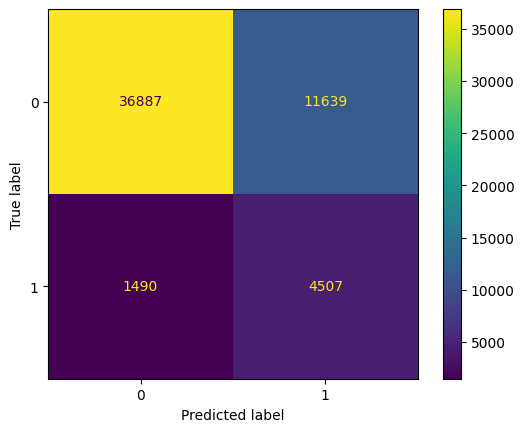

In [ ]:
confusion = confusion_matrix(true_y, predicted_labels)
ConfusionMatrixDisplay(confusion).plot()

In [ ]:
tn, fp, fn, tp = confusion.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ccr = (specificity+ sensitivity)/2
ppv = (tp / (tp + fp))
npv = (tn / (tn + fn))

print('sen:{}'.format(sensitivity))
print('spe:{}'.format(specificity))
print('CCR:{}'.format(ccr))
print('ppv:{}'.format(ppv))
print('nen:{}'.format(npv))

sen:0.7515424378856095
spe:0.7601491983678853
CCR:0.7558458181267473
ppv:0.27914034435773566
nen:0.9611746619068713




## ***Ten runs***

In [ ]:
random_seed_list = [123, 80, 789, 567, 890, 345, 678, 901, 456, 12]

In [ ]:
def runs(random_seed_list, data):

  ccr_list = []
  sen_list = []
  spe_list = []
  ppv_list = []
  npv_list = []
  auc_list = []
  i = 1

  for seed in random_seed_list:

        train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
        train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

        train_df1 = train_df1.reset_index(drop=True)
        test_df1 = test_df1.reset_index(drop=True)

        #balance the traininng data
        majority_class = train_df1[train_df1['labels'] == 0]
        minority_class = train_df1[train_df1['labels'] == 1]
        majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state = seed)
        train_df1 = pd.concat([minority_class, majority_undersampled])

        # preparing data for training
        PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        moldf = train_df1[pd.notnull(train_df1['Mol'])]

        moldf['Descriptors'] = moldf.Mol.apply(calcfp)
        X = np.array(list(moldf['Descriptors'])).astype(int)
        y = moldf['labels'].to_numpy()

        traindata = Data(X, y)
        train_loader = DataLoader(traindata, batch_size=50, shuffle=True)

        # fit the model
        model1 = BinaryClassificationModel()
        optimizer = optim.SGD(model1.parameters(), lr=0.1)
        train_model(model1, train_loader)

        # prepare evaluation dataevaluation
        PandasTools.AddMoleculeColumnToFrame(test_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        test = test_df1[pd.notnull(test_df1['Mol'])]

        test['Descriptors'] = test.Mol.apply(calcfp)
        X_test = np.array(list(test['Descriptors'])).astype(int)
        y_test = test['labels'].to_numpy()

        #predict and evaluate
        model1.eval()

        X_test_tensor = torch.from_numpy(X_test).float()
        X_test_1 = X_test_tensor.to(device)

        # Perform inference on the entire test set


        with torch.no_grad():
            test_outputs = model(X_test_1)
            test_outputs = test_outputs.to(device)

        # Convert test_outputs to a numpy array
        test_res = test_outputs.cpu().numpy()
        predicted_labels = (test_res > 0.5).astype(int).flatten()

        predicted_labels=torch.from_numpy(predicted_labels)

        # Convert y_test to a numpy array
        true_labels = torch.from_numpy(y_test)
        true_y = true_labels.cpu()

        test_outputs = test_outputs.cpu().numpy()

        # Calculate evaluation metrics
        roc_auc = roc_auc_score(true_y, test_outputs)
        cm = confusion_matrix(true_y, predicted_labels)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ccr = (specificity+ sensitivity)/2
        ppv = (tp / (tp + fp))
        npv = (tn / (tn + fn))

        ccr_list.append(ccr)
        sen_list.append(sensitivity)
        spe_list.append(specificity)
        ppv_list.append(ppv)
        npv_list.append(npv)
        auc_list.append(roc_auc)

        print('finished run:', i)
        i = i+1

  return ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list

In [ ]:
ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list = runs(random_seed_list, data)

[03:19:36] WARNING: not removing hydrogen atom without neighbors
[03:19:41] WARNING: not removing hydrogen atom without neighbors


Training finished


[03:23:06] WARNING: not removing hydrogen atom without neighbors


finished run: 1


[03:23:17] WARNING: not removing hydrogen atom without neighbors
[03:25:24] WARNING: not removing hydrogen atom without neighbors


Training finished
finished run: 2


[03:28:53] WARNING: not removing hydrogen atom without neighbors
[03:28:57] WARNING: not removing hydrogen atom without neighbors


Training finished


[03:32:03] WARNING: not removing hydrogen atom without neighbors


finished run: 3


[03:32:22] WARNING: not removing hydrogen atom without neighbors
[03:32:27] WARNING: not removing hydrogen atom without neighbors


Training finished


[03:35:41] WARNING: not removing hydrogen atom without neighbors


finished run: 4


[03:35:55] WARNING: not removing hydrogen atom without neighbors
[03:35:57] WARNING: not removing hydrogen atom without neighbors
[03:36:00] WARNING: not removing hydrogen atom without neighbors
[03:36:02] WARNING: not removing hydrogen atom without neighbors


Training finished
finished run: 5


[03:39:22] WARNING: not removing hydrogen atom without neighbors
[03:39:26] WARNING: not removing hydrogen atom without neighbors


Training finished


[03:42:32] WARNING: not removing hydrogen atom without neighbors


finished run: 6


[03:42:47] WARNING: not removing hydrogen atom without neighbors
[03:42:47] WARNING: not removing hydrogen atom without neighbors
[03:42:52] WARNING: not removing hydrogen atom without neighbors
[03:42:52] WARNING: not removing hydrogen atom without neighbors


Training finished
finished run: 7


[03:46:10] WARNING: not removing hydrogen atom without neighbors
[03:46:10] WARNING: not removing hydrogen atom without neighbors
[03:46:15] WARNING: not removing hydrogen atom without neighbors
[03:46:15] WARNING: not removing hydrogen atom without neighbors


Training finished
finished run: 8


[03:49:34] WARNING: not removing hydrogen atom without neighbors
[03:49:39] WARNING: not removing hydrogen atom without neighbors


Training finished
finished run: 9


[03:52:58] WARNING: not removing hydrogen atom without neighbors
[03:52:59] WARNING: not removing hydrogen atom without neighbors
[03:53:03] WARNING: not removing hydrogen atom without neighbors
[03:53:04] WARNING: not removing hydrogen atom without neighbors


Training finished
finished run: 10


In [ ]:
# Calculate mean and standard deviation
ccr_mean = np.mean(ccr_list)
ccr_std = np.std(ccr_list)

sen_mean = np.mean(sen_list)
sen_std = np.std(sen_list)

spe_mean = np.mean(spe_list)
spe_std = np.std(spe_list)

ppv_mean = np.mean(ppv_list)
ppv_std = np.std(ppv_list)

npv_mean = np.mean(npv_list)
npv_std = np.std(npv_list)

auc_mean = np.mean(auc_list)
auc_std = np.std(auc_list)

# Print the results
print(f'Mean and Standard Deviation of CCR: {ccr_mean:.2f} ± {ccr_std:.2f}')
print(f'Mean and Standard Deviation of Sensitivity: {sen_mean:.2f} ± {sen_std:.2f}')
print(f'Mean and Standard Deviation of Specificity: {spe_mean:.2f} ± {spe_std:.2f}')
print(f'Mean and Standard Deviation of PPV: {ppv_mean:.2f} ± {ppv_std:.2f}')
print(f'Mean and Standard Deviation of NPV: {npv_mean:.2f} ± {npv_std:.2f}')
print(f'Mean and Standard Deviation of AUC: {auc_mean:.2f} ± {auc_std:.2f}')

Mean and Standard Deviation of CCR: 0.76 ± 0.00
Mean and Standard Deviation of Sensitivity: 0.76 ± 0.01
Mean and Standard Deviation of Specificity: 0.76 ± 0.00
Mean and Standard Deviation of PPV: 0.29 ± 0.00
Mean and Standard Deviation of NPV: 0.96 ± 0.00
Mean and Standard Deviation of AUC: 0.83 ± 0.00
